# BEATS KBLT tomopy recon
#### Updated KBLT reconstruction script <br />
Author: [Gianluca Iori](mailto:gianluca.iori@sesame.org.jo)<br />
Created on: 06-11-2020 <br />
Modified on: 22-11-2021 <br />

see also:
https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html

#### Activate TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

`jupyter notebook &`

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
import recon_utils as ru

astropy module not found


In [3]:
matplotlib.rcParams['figure.dpi'] = 200

In [4]:
# thk_debian; bulb test
h5file = "/home/gianthk/Data/BEATS/kblt/bulb/wkblt_test_bulb_003.h5"
h5file_darks = "/home/gianthk/Data/BEATS/kblt/bulb/wkblt_test_bulb_darks_005.h5"
h5file_flats = "/home/gianthk/Data/BEATS/kblt/bulb/wkblt_test_bulb_flats_004.h5"
recon_file = "/home/gianthk/Data/BEATS/kblt/bulb/recon_writer/wkblt_test_bulb.tiff"

In [4]:
# thk debian; roman glass
h5file = "/home/gianthk/Data/BEATS/kblt/roman_glass/kblt_test_romanglass_cittadellascienza_030.h5"
h5file_flats = "/home/gianthk/Data/BEATS/kblt/roman_glass/kblt_test_romanglass_cittadellascienza_flats_031.h5"
h5file_darks = "/home/gianthk/Data/BEATS/kblt/roman_glass/kblt_test_romanglass_cittadellascienza_darks_032.h5"
recon_file = "/home/gianthk/Data/BEATS/kblt/roman_glass/recon/kblt_test_romanglass.tiff"

#### Read HDF5 data
- The `.read_aps_32id()` method of DXchange can read TOMCAT .h5 data
- If run without arguments (proj..), the import seem to be virtual (mem map)? I don't see this data in the RAM and I can reconstruct the whole volume on my laptop

In [5]:
# read the projections
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

In [7]:
print(projs.shape[:])
print(projs.dtype)

(501, 2160, 2368)
uint16


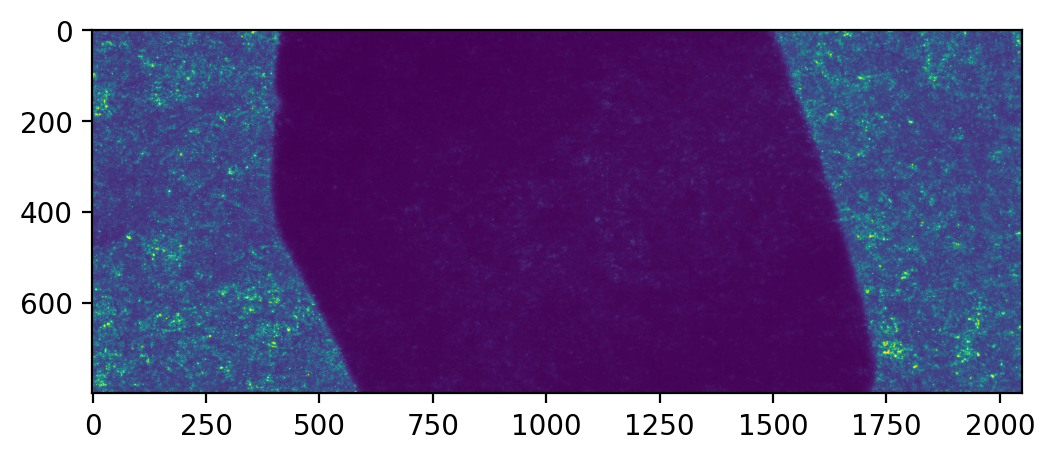

In [9]:
plt.imshow(projs[50, 11:810, :2050])
plt.show()

Check if theta exists

In [ ]:
theta

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case, theta is set as equally spaced between 0-180 degrees.

In [10]:
if theta is None:
    theta = tomopy.angles(projs.shape[0])

#### Read flats and darks
Flats and darks were acquired in separate files

In [6]:
# read the flats
flats, tmp, tmp2, tmp3 = dxchange.read_aps_32id(h5file_flats)

In [11]:
print(flats.shape[:])

(10, 2160, 2368)


In [7]:
# read the darks
darks, tmp, tmp2, tmp3 = dxchange.read_aps_32id(h5file_darks)

In [11]:
print(darks.shape[:])

(10, 2160, 2368)


In [8]:
del tmp, tmp2, tmp3

#### Crop data (optional)

In [9]:
projs = projs[:, 10:760, :2030]
flats = flats[:, 11:760, :2030]
darks = darks[:, 11:760, :2030]

#### Flat field correction

In [10]:
projs = tomopy.normalize(projs, flats, darks)
# print(projs.dtype)

ValueError: operands could not be broadcast together with shapes (501,750,2030) (749,2030) 

#### Calculate $ -log(projs) $ to linearize transmission tomography data.

In [11]:
projs = tomopy.minus_log(projs)

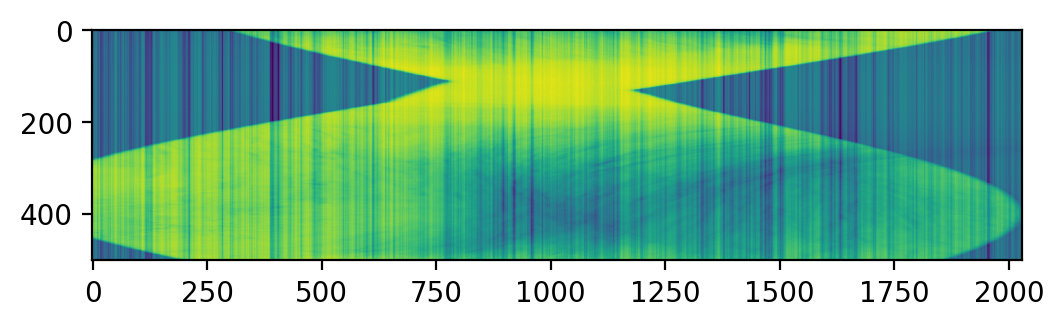

In [12]:
plt.imshow(projs[:, 600, :])
plt.show()

#### Automatic detect Center Of Rotation (COR)

In [13]:
# COR = tomopy.find_center(projs_corr, theta, init=projs_corr.shape[2]/2, ind=1250, tol=0.5)
COR = tomopy.find_center_vo(projs, ind=600)
print(COR)

1071.0


#### Reconstruction with CPU
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |
| **COR**   | Auto |


In [14]:
recon = tomopy.recon(projs, theta, center=COR, algorithm='gridrec', sinogram_order=False)

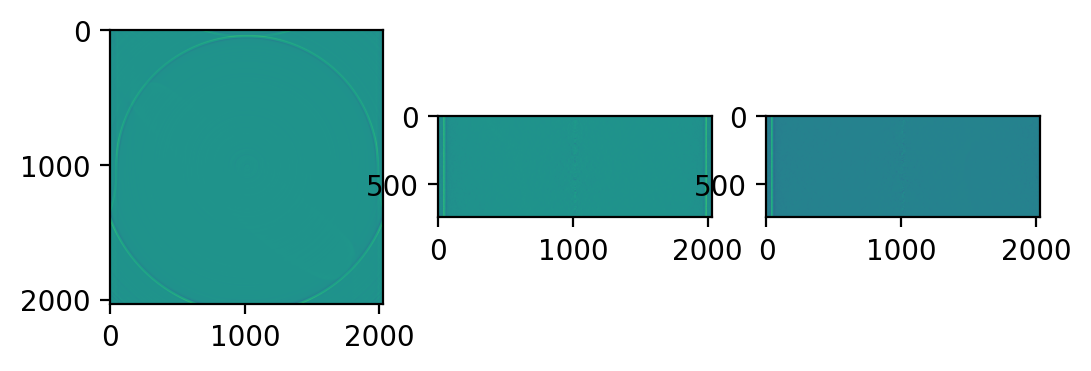

In [15]:
ru.plot_midplanes(recon)

#### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

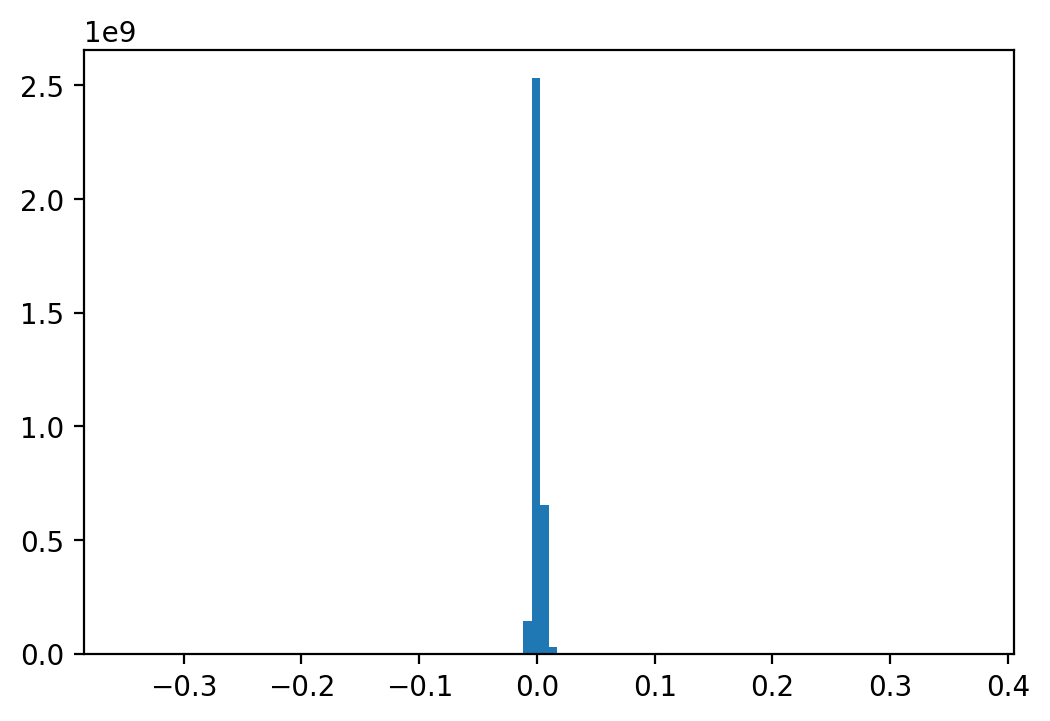

In [20]:
plt.hist(recon.ravel(), bins=100)
plt.show()

In [16]:
del projs, darks, flats

In [ ]:
recon = ru.touint8(recon, range=[-0.08, 0.08], numexpr=False)

In [15]:
recon.dtype

dtype('uint8')

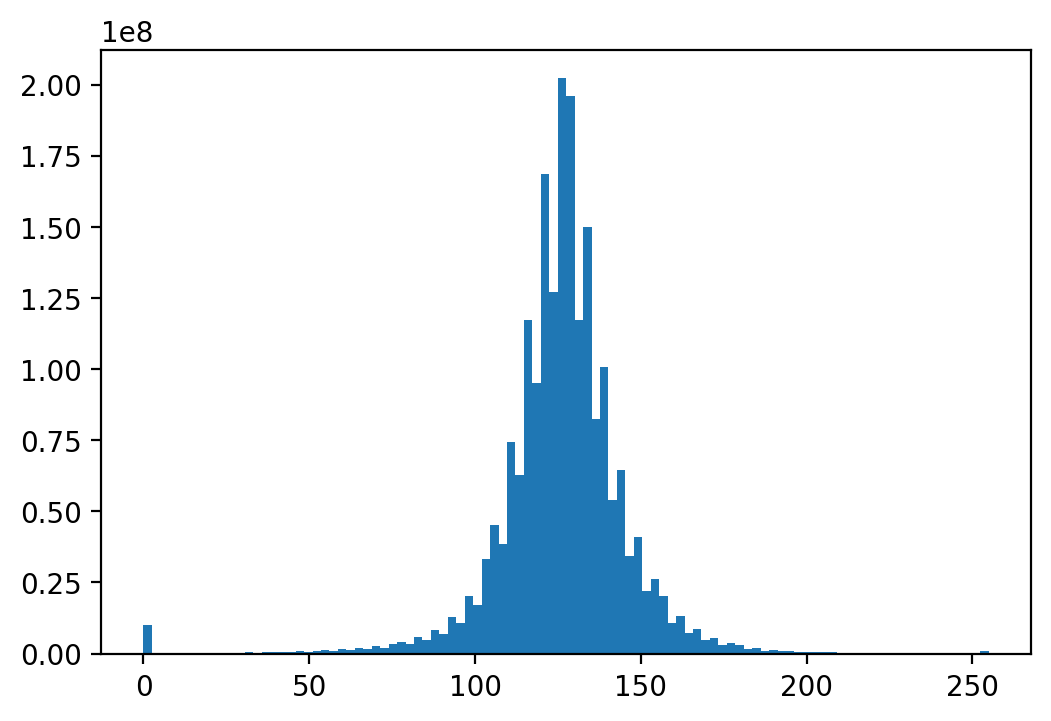

In [16]:
plt.hist(recon.ravel(), bins=100)
plt.show()

Apply circular mask (optional)

In [30]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

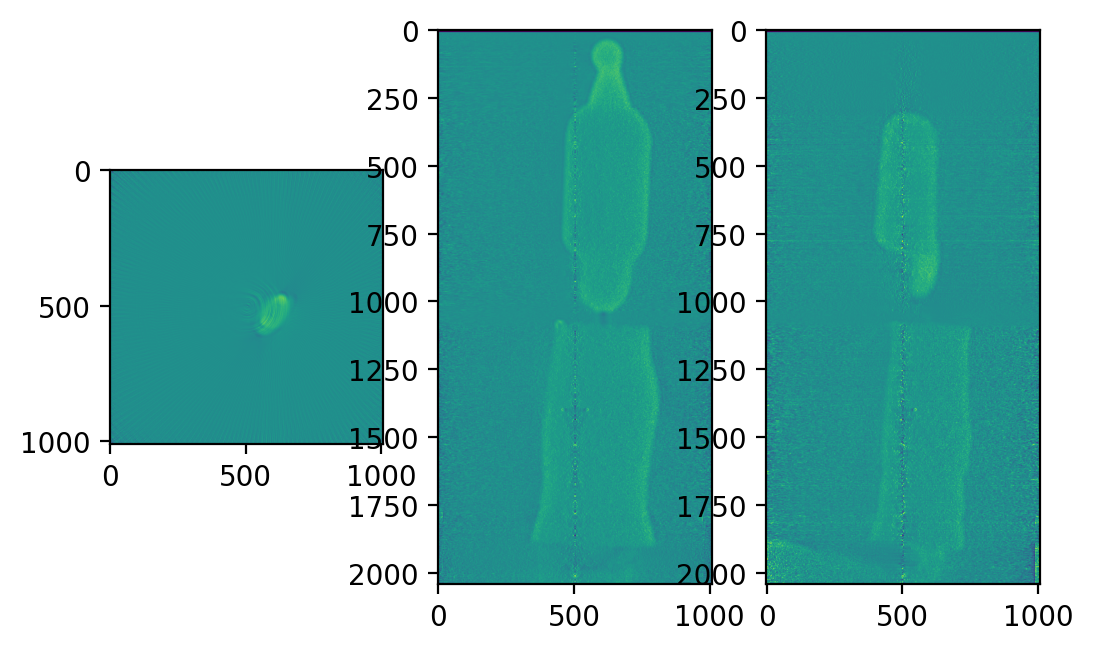

In [17]:
ru.plot_midplanes(recon)

---
here...
#### Write output Tiff stack as `uint8`

In [25]:
dxchange.writer.write_tiff_stack(recon, fname=recon_file, dtype='uint8', axis=0, digit=5, start=0, overwrite=True)

#### Open virtual stack in ImageJ

In [19]:
os.system(Fiji_exe_stack + '/home/gianthk/Data/StefanFly_test/test_00_/rec_8bit_0/test_00_001.rec.8bit.tif &')

0

#### Save images reconstructed with a range of rotation centers.

In [35]:
tomopy.write_center(projs, theta, dpath=path_recon+'tmp/COR', cen_range=[COR-10, COR+10, 1], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 20 slice groups with 8 master threads...


View them in Fiji

In [64]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/'+'{:04.2f}'.format(COR[0])+'.tiff &')

0

Optimize the reconstruction around given COR

In [67]:
tomopy.write_center(projs, theta, dpath=path_recon+'tmp/COR', cen_range=[482, 490, 0.5], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 16 slice groups with 8 master threads...


View them in Fiji

In [69]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/482.00.tiff &')

0